# Optimisation 

## Logistics (introduction, simple problem)

In this work we are going to use Pulp for supply chain and logistics optimisation.

In [1]:
import os 
import pandas as pd 
%matplotlib inline 
import matplotlib 
import matplotlib.pyplot as plt 
import numpy as np 
from pulp import *
from itertools import product
import random 

Let's imagine we have piano company, in fact, we just deliver piano, everyday we receive some orders, we have partners in three different regions and we are able to cooperate with each of them separately (one partner per day). We should develop an algorithm which let us minimize our costs. Every piano can be delivered separately, because it is fragile.

Let's initialize our markets and possible hubs and warehouses

In [2]:
markets = ['Paris', 'Hauts-de-Seine', 'Seine-Saint-Denis', 'Val-de-Marne'] # where we deliver
warehouses = ['Val-d Oise', 'Yvelines','Essonne'] # where our suppliers are
import numpy as np
import random
costs_dict = [(m,w) for m in markets for w in warehouses]
x = np.array([random.random() for i in range(12)])*1000
costs_dict = dict(zip(costs_dict,x))
# I initilize it with random numbers, but, usually we can use real data from experience of the company
costs = pd.DataFrame(columns=markets,index=warehouses)

In [3]:
demand = np.array([random.randrange(10) for i in range(4)]) 
# similarly demand is random, but integer, because we can deliver only the whole piano
demand = zip(demand,markets)
demand = pd.DataFrame(demand)
demand.columns = ['demand','market']
demand = demand.set_index('market')
demand

,demand
market,
Paris,9
Hauts-de-Seine,8
Seine-Saint-Denis,2
Val-de-Marne,7


In [4]:
for w in warehouses:
    for m in markets:
        costs.loc[(w,m)] = costs_dict[(m,w)]
costs

,Paris,Hauts-de-Seine,Seine-Saint-Denis,Val-de-Marne
Val-d Oise,381.733,252.552,621.94,786.634
Yvelines,570.05,611.508,654.286,383.275
Essonne,76.1259,261.686,380.647,716.849


In [5]:
model = LpProblem("Choose_the_warehouses", LpMinimize)
var_dict = LpVariable.dicts('stock-loc', 
                            [warehouse for warehouse in warehouses], 
                            lowBound=0, cat="Binary")
model += lpSum([var_dict[warehouse]*costs.loc[warehouse, market]*demand.loc[market, 'demand'] for warehouse in warehouses for market in markets])

We are allowed to open only one warehouse 

In [6]:
model += var_dict['Val-d Oise']+var_dict['Yvelines']+var_dict['Essonne'] == 1

In [7]:
model.solve()

1

In [8]:
# Print status
print(LpStatus[model.status])

# Print variables
for v in model.variables():
    print(v.name, "=", v.varValue)
print("Total Cost = ", value(model.objective))

Optimal
stock_loc_Essonne = 1.0
stock_loc_Val_d_Oise = 0.0
stock_loc_Yvelines = 0.0
Total Cost =  8557.859283176775


## Shawarma production 

## Unlimited demand

We are schawarma producers at the railway station hub, who are specialized on two specific recipes: Awarma and Schawarma. The traffic is really intensive, and our production capacity is not high enough to fulfill the whole demand. Price Schawarma is 11 euro, price of Awarma is equal to 15 euro. Ingredients of Schawarma are 120 grams vegetables, 1 naan bread, 100 grams of meat. Ingredients of awarma are 200 grams of meat, 1 naan bread, 50 grams of houmous. We have three suppliers who send the products only in batches
Vegetable and Houmous supplier (one kilogram of vegetable and one kilogram of houmous in batch)
Meat supplier (one kilogram  of meat per batch)
Naan supplier (100 naan per batch)
price of meat=50 euro/kg, vegetables = 35 euro/kg naan = 5 cents, houmous = 28 euro/kg
Everything we produced we are able to sell, however we cannon produce more than 1000 shawarmas/awarma per day, so what would be the appropriate production strategy?

In [9]:
s_price = 11
a_price = 15
# price per batch
meat_price = 50
vegetables_price = 35
houmous_price = 28
naan_price = 5

In [10]:
model = LpProblem("Maximize_Profits", LpMaximize)
awarma = LpVariable('awarma', lowBound=0,upBound=None, cat = 'Integer')
schawarma = LpVariable('schawarma', lowBound=0,upBound=None, cat = 'Integer')
ingredients = ['meat','vegetables','houmous', 'naan']
costs_ing = LpVariable.dicts('batched_ordered', ingredients, lowBound = 0, cat = 'Integer')

In [11]:
costs_ing

{'meat': batched_ordered_meat,
 'vegetables': batched_ordered_vegetables,
 'houmous': batched_ordered_houmous,
 'naan': batched_ordered_naan}

In [12]:
model += lpSum([awarma*a_price+
                schawarma*s_price-
                costs_ing['meat']*meat_price-
                costs_ing['vegetables']*vegetables_price-
                costs_ing['houmous']*houmous_price-
                costs_ing['naan']*naan_price])

In [13]:
model += awarma+schawarma <= 1000
model += 0.2*awarma+0.1*schawarma <= costs_ing['meat']
model += 0.12*schawarma <= costs_ing['vegetables']
model += 0.05*awarma <= costs_ing['houmous']
model += lpSum([awarma+schawarma])*0.01 <= costs_ing['naan']
# we have one supplier for houmous and vegetables, we can buy this products only together 
model += costs_ing['vegetables'] == costs_ing['houmous']

In [14]:
model.solve()
# Print status
print(LpStatus[model.status])

# Print variables
for v in model.variables():
    print(v.name, "=", v.varValue)
print("Total profit = ", value(model.objective))

Optimal
awarma = 700.0
batched_ordered_houmous = 35.0
batched_ordered_meat = 169.0
batched_ordered_naan = 10.0
batched_ordered_vegetables = 35.0
schawarma = 290.0
Total profit =  2985.0


Here is our solution, requested orders and the profit, which is maximized

## Limited demand

### Sensitivity analysis 

Suppose we are limited not by our capacity but by the demand, let’s say, our market became saturated and now can count on approximately 1000 schawarma and 750 awarma everyday to sell maximum. How should change our supply strategy?

In [15]:
model = LpProblem("Maximize_Profits", LpMaximize)
awarma = LpVariable('awarma', lowBound=0,upBound=None, cat = 'Integer')
schawarma = LpVariable('schawarma', lowBound=0,upBound=None, cat = 'Integer')
ingredients = ['meat','vegetables','houmous', 'naan']
costs_ing = LpVariable.dicts('batched_ordered', ingredients, lowBound = 0, cat = 'Integer')
model+=lpSum([awarma*a_price+ schawarma*s_price-costs_ing['meat']*meat_price-
              costs_ing['vegetables']*vegetables_price-costs_ing['houmous']*houmous_price-costs_ing['naan']*naan_price])
model += 0.2*awarma+0.1*schawarma <= costs_ing['meat']
model += 0.12*schawarma <= costs_ing['vegetables']
model += 0.05*awarma <= costs_ing['houmous']
model += lpSum([awarma+schawarma])*0.01 <= costs_ing['naan']
model += costs_ing['vegetables'] == costs_ing['houmous']
model += awarma <= 750
model += schawarma<= 1000
model.solve()
for v in model.variables():
    print(v.name, "=", v.varValue)
print("Total profit = ", value(model.objective))

awarma = 747.0
batched_ordered_houmous = 38.0
batched_ordered_meat = 181.0
batched_ordered_naan = 11.0
batched_ordered_vegetables = 38.0
schawarma = 316.0
Total profit =  3182.0


In [16]:
print("Model Status: {}".format(LpStatus[model.status]))
for v in model.variables():
    print(v.name, "=", v.varValue)
print("Objective = ", value(model.objective))
pd.options.display.float_format = '{:.2f}'.format
# Print Shadow Price and Slack
o = [{'name': name, 'shadow price': c.pi, 'slack': c.slack} 
     for name, c in model.constraints.items()]
print(pd.DataFrame(o))

Model Status: Optimal
awarma = 747.0
batched_ordered_houmous = 38.0
batched_ordered_meat = 181.0
batched_ordered_naan = 11.0
batched_ordered_vegetables = 38.0
schawarma = 316.0
Objective =  3182.0
  name  shadow price  slack
0  _C1         -0.00   0.00
1  _C2         -0.00   0.08
2  _C3         -0.00   0.65
3  _C4         -0.00   0.37
4  _C5         -0.00  -0.00
5  _C6         -0.00   3.00
6  _C7         -0.00 684.00


We have an unmet demand in terms of schawarma sold, how could we fix it? First we should understand the nature of our supplies. We can fix it by change our supplies strategy or introducing another low margin product, which would use some houmous, so we will be able to use it, instead of changing our suppliers and order additional vegetables.

We are going to use houmous salad to sell some houmous we have to order because we order salad, it is going to be only 100 grams of houmous and the price will be 3 euro (the cost of 100 gramms of 2.8 euro). We think that half of our customers would accept such offer

In [17]:
model = LpProblem("Maximize_Profits", LpMaximize)
salad_price = 3
awarma = LpVariable('awarma', lowBound=0,upBound=None, cat = 'Integer')
schawarma = LpVariable('schawarma', lowBound=0,upBound=None, cat = 'Integer')
salad = LpVariable('salad', lowBound=0,upBound=None, cat = 'Integer')
ingredients = ['meat','vegetables','houmous', 'naan']
costs_ing = LpVariable.dicts('batched_ordered', ingredients, lowBound = 0, cat = 'Integer')
model+=lpSum([awarma*a_price+ schawarma*s_price+ salad*salad_price
              -costs_ing['meat']*meat_price
              -costs_ing['vegetables']*vegetables_price
              -costs_ing['houmous']*houmous_price
              -costs_ing['naan']*naan_price])
model += 0.2*awarma+0.1*schawarma <= costs_ing['meat']
model += 0.12*schawarma <= costs_ing['vegetables']
model += 0.05*awarma+0.03*salad <= costs_ing['houmous']
model += lpSum([awarma+schawarma])*0.01 <= costs_ing['naan']
model += costs_ing['vegetables'] == costs_ing['houmous']
model += awarma <= 750
model += schawarma<= 1000
model += salad <= 0.5*lpSum([awarma+schawarma])
model.solve()
for v in model.variables():
    print(v.name, "=", v.varValue)
print("Total profit = ", value(model.objective))

awarma = 750.0
batched_ordered_houmous = 60.0
batched_ordered_meat = 200.0
batched_ordered_naan = 13.0
batched_ordered_vegetables = 60.0
salad = 625.0
schawarma = 500.0
Total profit =  4780.0


As we can see, without introducing highly margin product, just due to optimization of supply chain (basically, our product line now have better fit to our supplies) we can achieve a dramatic increase in our profit (almost 1.5 thousand per day), let’s look through sensitivity analyses.

In [18]:
# Print Shadow Price and Slack
o = [{'name': name, 'shadow price': c.pi, 'slack': c.slack} 
     for name, c in model.constraints.items()]
print(pd.DataFrame(o))

  name  shadow price  slack
0  _C1         -0.00   0.00
1  _C2         -0.00  -0.00
2  _C3         -0.00   3.75
3  _C4         -0.00   0.50
4  _C5         -0.00  -0.00
5  _C6         -0.00  -0.00
6  _C7         -0.00 500.00
7  _C8         -0.00   0.00


However, the demand is not a constant in the next part we will check our model, by running it through monte-carlo simulation

### Monte-Carlo Simulation

In [19]:
columns_names = ['Awarma_produced','Houmous_kg_ordered', 'mead_kg_ordered',
           'naan_packages_ordered', 'vegetables_kg_ordered','Salad_produced','Schawarma_produced', 'Profit']
df = pd.DataFrame(columns=columns_names)
counter = 0
model = LpProblem("Maximize Profits", LpMaximize)
awarma = LpVariable('awarma', lowBound=0,upBound=None, cat = 'Integer')
schawarma = LpVariable('schawarma', lowBound=0,upBound=None, cat = 'Integer')
salad = LpVariable('salad', lowBound=0,upBound=None, cat = 'Integer')
ingredients = ['meat','vegetables','houmous', 'naan']
costs_ing = LpVariable.dicts('batched_ordered', ingredients, lowBound = 0, cat = 'Integer')
model+=lpSum([awarma*a_price+ schawarma*s_price+ salad*salad_price
              -costs_ing['meat']*meat_price
              -costs_ing['vegetables']*vegetables_price
              -costs_ing['houmous']*houmous_price
              -costs_ing['naan']*naan_price])
model += 0.2*awarma+0.1*schawarma <= costs_ing['meat']
model += 0.12*schawarma <= costs_ing['vegetables']
model += 0.05*awarma+0.03*salad <= costs_ing['houmous']
model += lpSum([awarma+schawarma])*0.01 <= costs_ing['naan']
model += costs_ing['vegetables'] == costs_ing['houmous']
while counter<1000:
    counter +=1
# now we are limited by the demand
    model += awarma <= 750+random.normalvariate(0,50)
    model += schawarma<= 1000+random.normalvariate(0,50)
    # salad sales are now connected to the overall demand within one day
    model += salad <= 0.5*lpSum([awarma+schawarma])
    model.solve()
    temp = dict(zip(columns_names[:-1],[v.varValue for v in model.variables()]))
    temp['Profit']= value(model.objective)
    df = df.append(temp, ignore_index=True)
df.head()

C:\Users\eldar\Anaconda3\lib\site-packages\pulp\pulp.py:1114: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


,Awarma_produced,Houmous_kg_ordered,mead_kg_ordered,naan_packages_ordered,vegetables_kg_ordered,Salad_produced,Schawarma_produced,Profit
0,779.00,59.00,205.00,13.00,59.00,635.00,491.00,4959.00
1,671.00,55.00,180.00,12.00,55.00,564.00,458.00,4270.00
2,671.00,55.00,180.00,12.00,55.00,564.00,458.00,4270.00
3,671.00,55.00,180.00,12.00,55.00,564.00,458.00,4270.00
4,671.00,55.00,180.00,12.00,55.00,564.00,458.00,4270.00


In [20]:
matrix = [list(df.columns[:2]),list(df.columns[2:4]),list(df.columns[4:6]), list(df.columns[6:8])]
matrix

[['Awarma_produced', 'Houmous_kg_ordered'],
 ['mead_kg_ordered', 'naan_packages_ordered'],
 ['vegetables_kg_ordered', 'Salad_produced'],
 ['Schawarma_produced', 'Profit']]

In [21]:
df.describe()

,Awarma_produced,Houmous_kg_ordered,mead_kg_ordered,naan_packages_ordered,vegetables_kg_ordered,Salad_produced,Schawarma_produced,Profit
count,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00
mean,610.30,46.40,160.60,10.09,46.40,497.83,385.39,3883.59
std,13.03,1.68,3.95,0.36,1.68,13.26,14.22,83.20
min,604.00,46.00,159.00,10.00,46.00,493.00,382.00,3843.00
25%,604.00,46.00,159.00,10.00,46.00,493.00,382.00,3843.00
50%,604.00,46.00,159.00,10.00,46.00,493.00,382.00,3843.00
75%,614.00,46.00,161.00,10.00,46.00,498.00,382.00,3908.00
max,779.00,59.00,205.00,13.00,59.00,635.00,491.00,4959.00


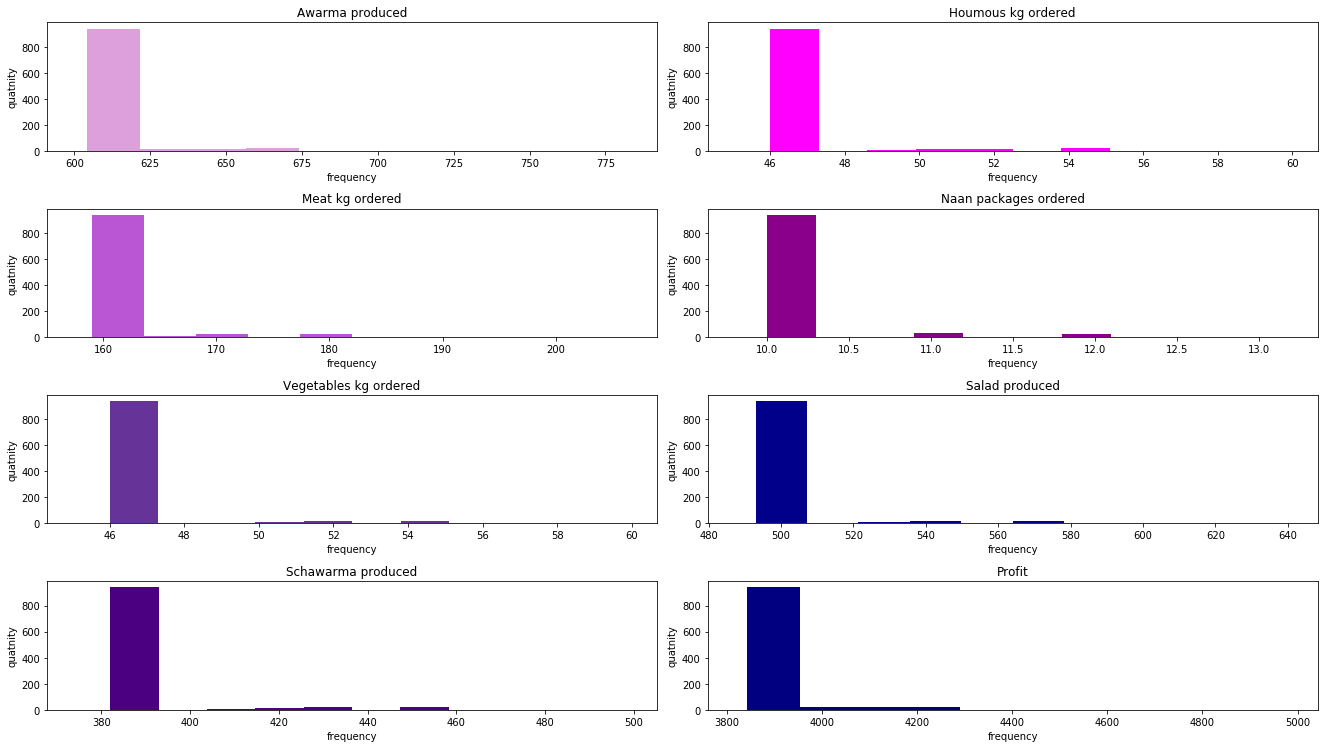

In [22]:
graphs_names = [['Awarma produced','Houmous kg ordered'],
           ['Meat kg ordered', 'Naan packages ordered'], 
            ['Vegetables kg ordered','Salad produced'],
               ['Schawarma produced', 'Profit']]
colors = [[ 'plum','magenta'],
          [ 'mediumorchid','darkmagenta'],
         ['rebeccapurple','darkblue'],
         ['indigo','navy']]
fig, ax = plt.subplots(4, 2)
fig.set_size_inches(18.5, 10.5)
fig.tight_layout()
for i in list(range(4)):
    for j in list(range(2)):
        subax = ax[i,j]
        subax.hist(df[matrix[i][j]], color=colors[i][j])
        subax.set_title(graphs_names[i][j])
        subax.set_xlim(max(0,df[matrix[i][j]].min()-np.std(df[matrix[i][j]])),df[matrix[i][j]].max()+np.std(df[matrix[i][j]]))
        subax.set(xlabel = 'frequency', ylabel = 'quatnity')
plt.tight_layout()
plt.show()

By that moment, one can be probably wondering, why do we need such visualizations  and simulations? In short, it gives an idea of how much safe stocks the company should have which would be covered in future projects